In [1]:
import uproot 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px


In [3]:
my_tuple = uproot.open("Lb2JpsiLambda_newstart.root:Hlt2BandQ_Lb2JpsiLambdaTTTuple/Tuple")

In [14]:
my_tuple.keys()

['EVENTNUMBER',
 'Hlt2_Hlt2BandQ_Lb2JpsiLambdaTTDecision',
 'Hlt2_TCK',
 'RUNNUMBER',
 'Lb_END_VZ',
 'Lb_END_VX',
 'Lb_END_VY',
 'Lb_END_VRHO',
 'Lb_BPVCORRM',
 'Lb_BPVDIRA',
 'Lb_BPVETA',
 'Lb_BPVIPCHI2',
 'Lb_BPVFDCHI2',
 'Lb_BPVLTIME',
 'Lb_BPVFD',
 'Lb_BPVFDIRX',
 'Lb_BPVFDIRY',
 'Lb_BPVFDIRZ',
 'Lb_BPVFDVECX',
 'Lb_BPVFDVECY',
 'Lb_BPVFDVECZ',
 'Lb_BPVIP',
 'Lb_BPVVDRHO',
 'Lb_BPVVDX',
 'Lb_BPVVDY',
 'Lb_BPVVDZ',
 'Lb_COMB_MASS',
 'Lb_MAXDOCA',
 'Lb_MAXDOCACHI2',
 'Lb_MAXSDOCA',
 'Lb_MAXSDOCACHI2',
 'Lb_TRUEID',
 'Lb_TRUEKEY',
 'Lb_TRUEPT',
 'Lb_TRUEPX',
 'Lb_TRUEPY',
 'Lb_TRUEPZ',
 'Lb_TRUEENERGY',
 'Lb_TRUEP',
 'Lb_TRUEFOURMOMENTUME',
 'Lb_TRUEFOURMOMENTUMX',
 'Lb_TRUEFOURMOMENTUMY',
 'Lb_TRUEFOURMOMENTUMZ',
 'Lb_TRUEORIGINVZ',
 'Lb_TRUEORIGINVX',
 'Lb_TRUEORIGINVY',
 'Lb_TRUEENDVZ',
 'Lb_TRUEENDVX',
 'Lb_TRUEENDVY',
 'Lb_BKGCAT',
 'Lb_MC_MOTHER_ID',
 'Lb_MC_MOTHER_KEY',
 'Lb_MC_GD_MOTHER_ID',
 'Lb_MC_GD_MOTHER_KEY',
 'Lb_MC_GD_GD_MOTHER_ID',
 'Lb_MC_GD_GD_MOTHER_KEY',
 'Lb_MASS

In [15]:
#keys = my_tuple.keys()
keys = ["Lb_BPVIP","Lb_MAXSDOCA","Lb_PT","Lb_CHI2","Lambda0_TRUEENDVZ","Lb_BKGCAT","p_plus_MINIP","p_plus_PID_K"]

In [16]:
signal_data = my_tuple.arrays(keys,library="pd", cut="(Lb_BKGCAT==0)&(Lambda0_TRUEENDVZ > 2500)")
bg_data = my_tuple.arrays(keys,library="pd", cut="(Lb_BKGCAT!=0)|(Lambda0_TRUEENDVZ < 2500)")

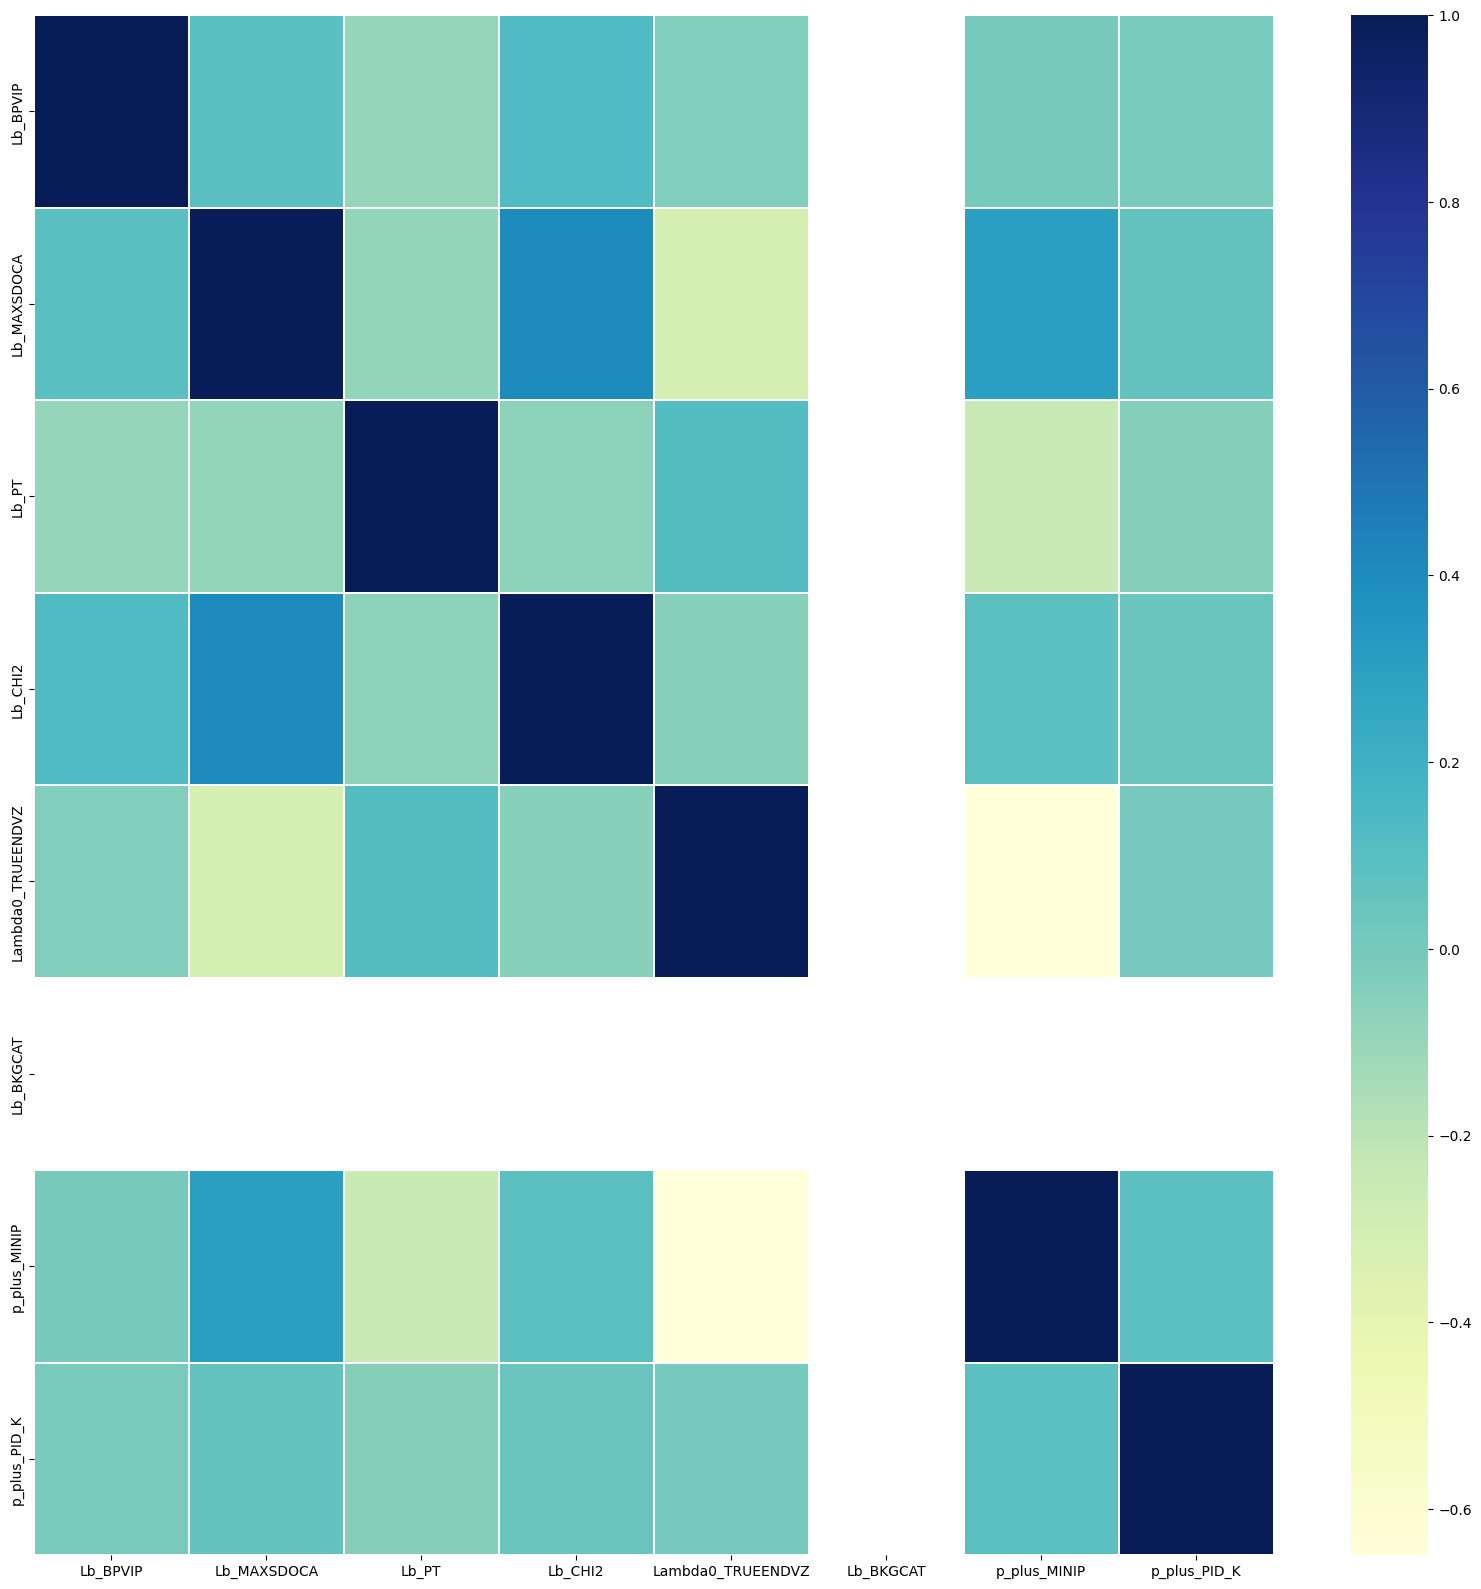

In [17]:
f, ax = plt.subplots(figsize =(20, 20))
sns.heatmap(signal_data.corr(), ax = ax, cmap ="YlGnBu", linewidths = 0.1)
plt.show()

In [32]:
training_data = signal_data.merge(bg_data.dropna().sample(len(signal_data)),how='outer')
training_data

,Lb_BPVIP,Lb_MAXSDOCA,Lb_PT,Lb_CHI2,Lambda0_TRUEENDVZ,Lb_BKGCAT,p_plus_MINIP,p_plus_PID_K
0,0.023786,0.128070,8501.947266,8.018241,6664.610840,0,74.407280,0.000000
1,0.007850,0.456041,3576.970215,1.022276,6023.783203,0,24.293640,2.048832
2,0.022421,3.414481,10190.497070,0.885457,4383.386230,0,35.877403,1.684036
3,0.070501,24.366753,3056.674561,9.849626,5065.246094,0,81.085091,0.443821
4,0.051971,13.112944,6154.324707,3.378011,3995.272217,0,115.392990,5.936031
...,...,...,...,...,...,...,...,...
3437,0.026505,8.594846,2002.807373,3.004829,1374.403687,0,131.103134,-1.148392
3438,0.041543,25.958363,2296.587646,4.536073,2467.106689,0,132.229553,0.351442
3439,0.032662,7.326281,9252.686523,5.266425,1716.260254,0,100.777481,9.031223
3440,0.131518,23.951756,7763.169434,12.979105,3227.836426,100,230.171539,-34.865555


In [33]:
training_data['SIGNAL'] = False
mask =(training_data['Lb_BKGCAT'] == 0)
training_data.loc[mask,'SIGNAL'] = True
mask = (training_data['Lambda0_TRUEENDVZ'] < 2500)
training_data.loc[mask,'SIGNAL'] = False

In [34]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

In [35]:
to_drop = ["SIGNAL", "Lb_BKGCAT", "Lambda0_TRUEENDVZ"]


In [36]:
X_tr, X_eval = train_test_split(training_data)
y_tr = X_tr.SIGNAL
y_tr_clean = y_tr == True
X_tr_copy = X_tr.copy()
X_tr.drop(columns=to_drop, inplace=True)

In [38]:
y_eval =  X_eval.SIGNAL
y_eval_clean = y_eval == True
X_eval_copy = X_eval.copy()
X_eval.drop(columns=to_drop, inplace=True)

In [39]:
X_eval.columns

Index(['Lb_BPVIP', 'Lb_MAXSDOCA', 'Lb_PT', 'Lb_CHI2', 'p_plus_MINIP',
       'p_plus_PID_K'],
      dtype='object')

In [53]:
model_params = {
    'iterations': 50, 
    'loss_function': 'Logloss',
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'od_type': 'IncToDec',
}

In [54]:
train_dataset = Pool(X_tr, y_tr_clean, feature_names=list(X_tr.columns))
eval_dataset = Pool(X_eval, y_eval_clean, feature_names=list(X_eval.columns))

In [55]:
model = CatBoostClassifier(**model_params,custom_metric=['Logloss',
                   'AUC:hints=skip_train~false','Accuracy'])
model.fit(train_dataset, verbose=True, plot=False)

Learning rate set to 0.240886
0:	learn: 0.6548547	total: 1.38ms	remaining: 67.5ms
1:	learn: 0.6302191	total: 2.4ms	remaining: 57.5ms
2:	learn: 0.6151803	total: 3.29ms	remaining: 51.6ms
3:	learn: 0.6020850	total: 4.22ms	remaining: 48.5ms
4:	learn: 0.5902560	total: 5.1ms	remaining: 45.9ms
5:	learn: 0.5821131	total: 5.98ms	remaining: 43.9ms
6:	learn: 0.5738649	total: 6.87ms	remaining: 42.2ms
7:	learn: 0.5688431	total: 7.75ms	remaining: 40.7ms
8:	learn: 0.5633991	total: 8.64ms	remaining: 39.4ms
9:	learn: 0.5600515	total: 9.58ms	remaining: 38.3ms
10:	learn: 0.5556234	total: 10.5ms	remaining: 37.2ms
11:	learn: 0.5524040	total: 11.4ms	remaining: 36ms
12:	learn: 0.5499590	total: 12.3ms	remaining: 35ms
13:	learn: 0.5473032	total: 13.2ms	remaining: 33.9ms
14:	learn: 0.5448057	total: 14.1ms	remaining: 32.8ms
15:	learn: 0.5428601	total: 14.9ms	remaining: 31.7ms
16:	learn: 0.5408608	total: 15.8ms	remaining: 30.7ms
17:	learn: 0.5396257	total: 16.6ms	remaining: 29.6ms
18:	learn: 0.5373731	total: 17.5

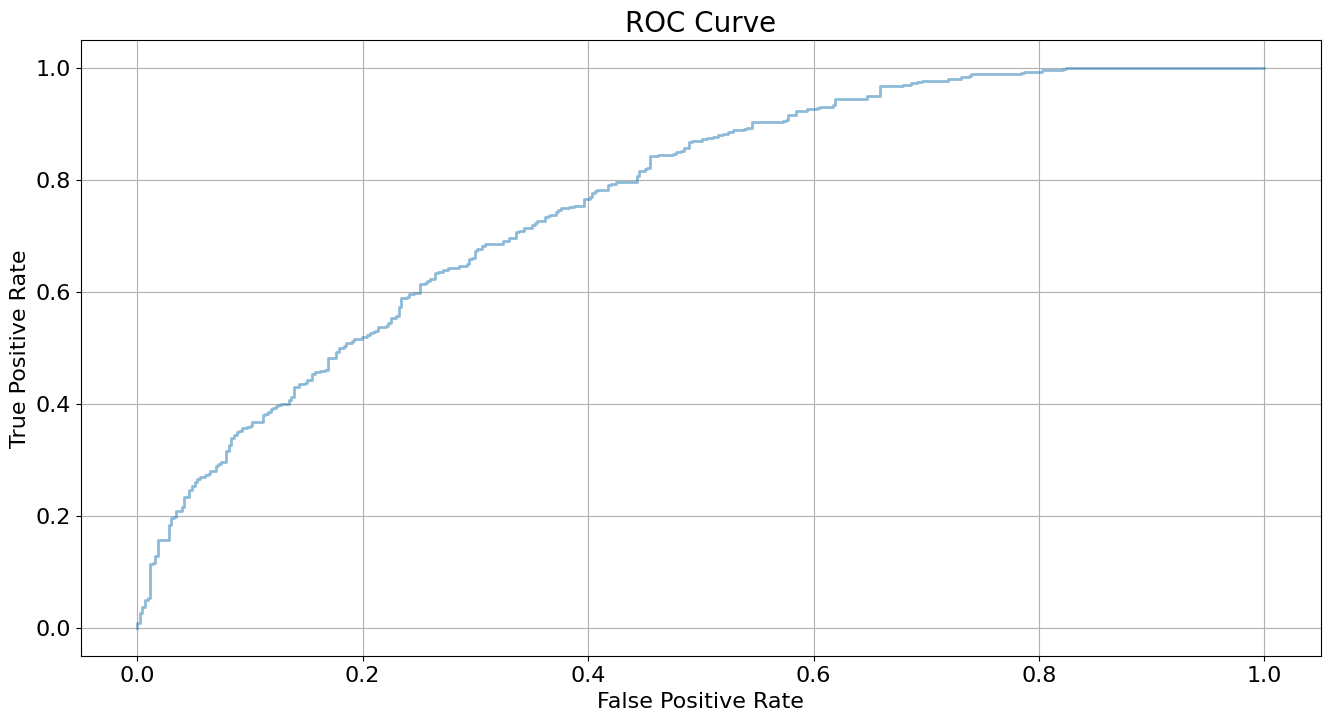

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00232019, 0.00232019, 0.00232019, 0.00232019, 0.00232019,
        0.00232019, 0.00232019, 0.00232019, 0.00464037, 0.00464037,
        0.00464037, 0.00464037, 0.00464037, 0.00464037, 0.00696056,
        0.00696056, 0.00696056, 0.00696056, 0.00696056, 0.00696056,
        0.00928074, 0.00928074, 0.00928074, 0.01160093, 0.01160093,
        0.01160093, 0.01160093, 0.01160093, 0.01160093, 0.01160093,
        0.01160093, 0.01160093, 0.01160093, 0.01160093, 0.01160093,
        0.01160093, 0.01160093, 0.01160093, 0.01160093, 0.01160093,
        0.01160093, 0.01160093, 0.01160093, 0.01160093, 0.01160093,
        0.01160093, 0.01160093, 0.01160093, 0.01160093, 0.01160093,
        0.01392111, 0.01392111, 0.0162413 , 0.0162413 , 0.0162413 ,
        0.0162413 , 0.0162413 , 0.0162413 , 0.01856148, 0.01856148,
        0.01856148, 0.01856148, 0.01856148, 0.01856148, 0.01856148,
        0.01856148, 0.01856148, 0.01856148, 0.01

In [56]:
plt.rcParams["figure.figsize"] = (4,4)
get_roc_curve(model, 
              eval_dataset,
              thread_count=-1,
              plot=True)

In [57]:
print(model.get_best_score())


{'learn': {'Accuracy': 0.7636574970941495, 'Logloss': 0.4859726345049092, 'AUC': 0.8491542521571523}}


Text(0.5, 0, 'CatBoost Feature Importance')

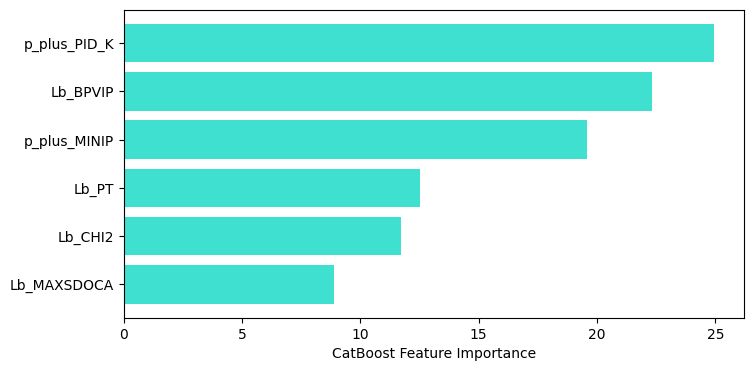

In [58]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (8,4)
plt.barh(X_eval.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [59]:
signal_MVA_prob_eval = model.predict_proba(X_eval_copy)
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_eval]
X_eval_copy['signal_MVA'] = signal_MVA_probs

signal_MVA_prob_tr = model.predict_proba(X_tr_copy)
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_tr]
X_tr_copy['signal_MVA'] = signal_MVA_probs

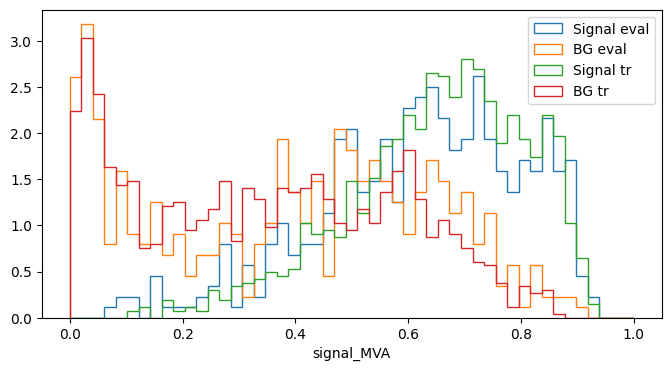

In [61]:
fig, ax = plt.subplots()

density = True

variable = 'signal_MVA'

bins = np.linspace(0,1,50)

n_sig,bins_sig, _ = ax.hist(X_eval_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal eval",histtype='step',density=density)
n_bg,bins_bg, _ = ax.hist(X_eval_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG eval",histtype='step',density=density)

ax.hist(X_tr_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal tr",histtype='step',density=density)
ax.hist(X_tr_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG tr",histtype='step',density=density)

ax.legend()

plt.xlabel(variable)
plt.show()

In [62]:
len(signal_data)

1721